## UTS Machine Vision: Menghitung Objek dan Segmentasi
**Nama Kelompok:**
1. Luigi Ifan Dwiutomo (0922040056)
2. Moch. Baharudin Yusuf Habibie (0922040058)

### Import Library

In [ ]:
import cv2 as cv
import numpy as np
import sys
from PyQt5.QtWidgets import QApplication, QWidget, QLabel, QPushButton, QVBoxLayout, QHBoxLayout, QFileDialog, QGridLayout, QMessageBox
from PyQt5.QtGui import QPixmap, QImage, QIcon
from PyQt5.QtCore import Qt
from processing import preprocess, threshold, postprocess, draw_bounding_boxes, scaling

### Preprocessing

**Scaling**

In [ ]:
def scaling(image, width=800, height=600):
    dsize = (width, height) # Set size for standardization
    resized_image = cv.resize(image, dsize, interpolation=cv.INTER_LINEAR) # Resize the image
    return resized_image 

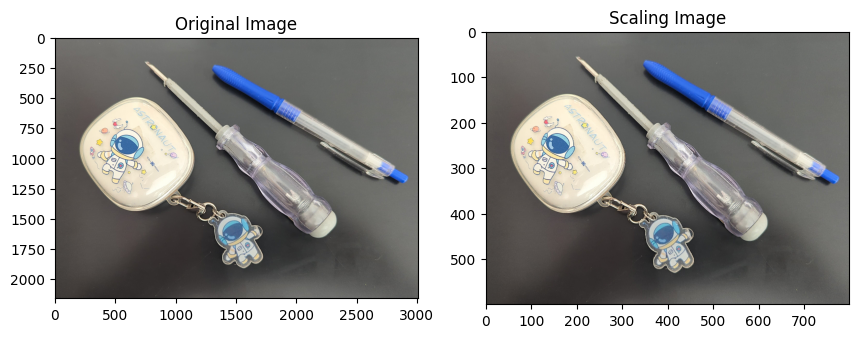
<br>
**Insight:**
- Mengubah ukuran gambar ke dimensi yang lebih kecil atau standarisasi ukuran ke 800x600 pixel dengan menggunakan metode downsampling Interpolasi Linear.

**Grayscale Converter, Gamma Correction, Histogram Equalization**

In [ ]:
def preprocess(original):
    gray_im = cv.cvtColor(original, cv.COLOR_BGR2GRAY) # Convert to grayscale
    gamma_correct = np.array(255 * (gray_im / 255) ** 1.2, dtype='uint8') # Gamma correction y = 1.2 
    gray_equ = cv.equalizeHist(gamma_correct) # Histogram equalization
    return gamma_correct, gray_equ, gray_im

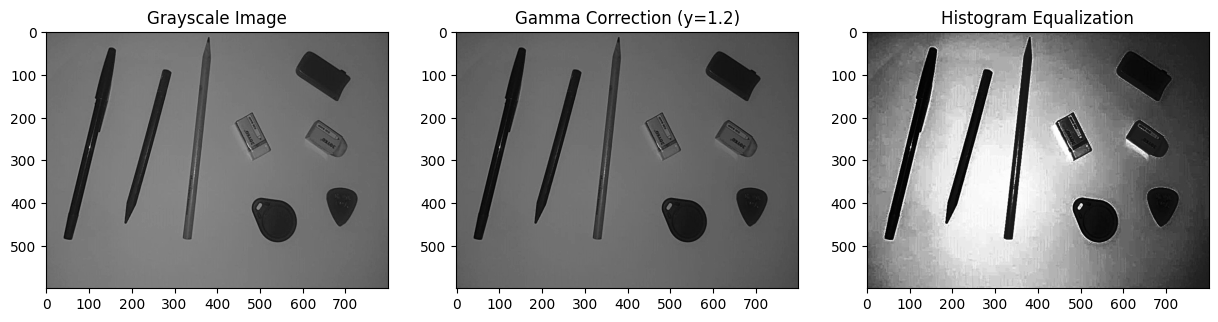
<br>
**Insight:**
- Mengonversi gambar menjadi grayscale dengan fungsi `cv.cvtColor`.
- Mengatur kontras menggunakan gamma correction dengan nilai **y = 1.2** yang mengubah intensitas piksel menggunakan rumus **y = 255 x (x/255) 1.2**, dimana **x** adalah intensitas piksel dan **y** adalah intensitas yang sudah dikoreksi. Hal ini membantu memperbaiki pencahayaan yg tidak merata, sehingga objek lebih mudah dideteksi.
- Menyesuaikan kontras dengan histogram equalization yg mendistribusikan ulang intensitas piksel secara merata sehingga meningkatkan kontras gambar. Teknik ini digunakan karena dapat memperjelas objek yg sebelumnya tersembunyi dalam area gelap atau terang.

## Processing

**Adaptive Thresholding**

In [ ]:
def thresholding(gray_correct):
    thresh = cv.adaptiveThreshold( # Apply adaptive thresholding
        gray_correct, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv.THRESH_BINARY, 255, 19
    )
    thresh = cv.bitwise_not(thresh) # Invert the image
    return thresh

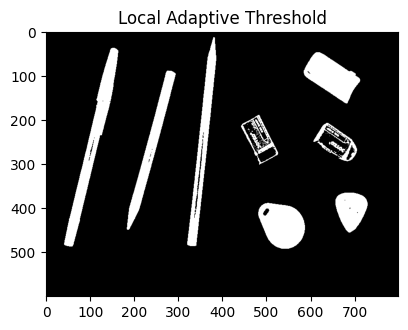
<br>
**Insight:**
- Melakukan Adaptive Thresholding untuk mengubah gambar grayscale menjadi gambar biner (hitam-putih) dengan ambang batas yg disesuaikan secara lokal berdasarkan piksel-piksel disekitarnya.
- Metode ini menggunakan rata-rata berbobot **Gaussian** untuk menentukan ambang batas lokal pada setiap piksel.
- Dilakukan inverting dari hasil thresholding dengan mengubah piksel dengan nilai 0 mejadi 255 dan nilai 255 menjadi 0 untuk meningkatkan visibilitas objek dalam citra.

**Morphological Operation**

In [ ]:
def postprocess(thresh):
    kernel = np.ones((7, 7), np.uint8) # Create a kernel for morphological operations
    img_dilation = cv.dilate(thresh, kernel, iterations=2) 
    img_erode = cv.erode(img_dilation, kernel, iterations=1)
    img_closed = cv.morphologyEx(img_erode, cv.MORPH_CLOSE, kernel)
    img_closed = cv.medianBlur(img_closed, 7) # Apply median blur to reduce noise

    # Labeling & Segmentation
    ret, labels = cv.connectedComponents(img_closed) # Connected components labeling
    label_hue = np.uint8(179 * labels / np.max(labels)) # Normalize labels to hue range
    blank_ch = 255 * np.ones_like(label_hue)
    labeled_img = cv.merge([label_hue, blank_ch, blank_ch])
    labeled_img = cv.cvtColor(labeled_img, cv.COLOR_HSV2BGR)
    labeled_img[label_hue == 0] = 0 # Set background to black
    return img_closed, labeled_img

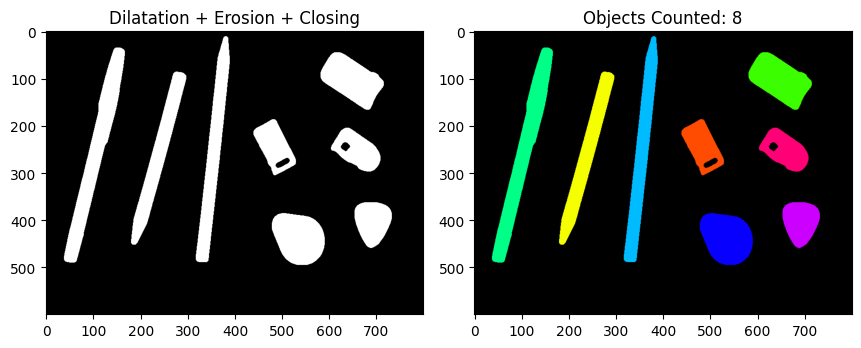
<br>
**Insight:**
- Melakukan morfologi pada gambar yakni Dilatasi, Erosi dan Closing dengan membuat kernel berupa array 7x7 yang memberikan ruang cukup untuk mengubah objek dan berisi nilai 1 yang berarti semua piksel dalam kernel memiliki bobot yg sama.
- Dilatasi membantu memperbesar objek dan menghubungkan bagian objek yang terpisah.
- Erosi digunakan untuk mengurangi objek tetapi menjaga bentuk objek dari gambar yang telah diperbesar atau melalui dilatasi dan mencegah objek mengecil terlalu banyak.
- Membuat kernel baru untuk operasi closing dimana operasi morfologi untuk menutup lubang atau celah kecil di antara objek.
- Fungsi `cv.medianBlur` digunakan untuk mengurangi noise pada gambar dengan filter median yang bekerja dengan cara menggantikan setiap piksel dengan nilai median dari piksel-piksel sekitarnya dalam jendela kernel 7x7.
- Median Blur efektif untuk menghilangkan noise yang muncul setelah operasi dilatasi dan erosi, terutama pada piksel-piksel yang tidak diinginkan yg dapat menggangu deteksi objek.
- Melakukan labeling pada objek menggunakan fungsi `cv.connectedComponents` yang menandai objek terhubung dalam gambar biner. **ret** adalah jumlah total komponen yang terhubung dalam gambar, sedangkan **labels** adalah gambar yg disertai label untuk menunjukkan setiap objek terhubung yg terindentifikasi.
- Menyesuaikan nilai label untuk perwarnaan menggunakan nilai hue dalam ruang warna HSV dengan normalisasi nilai label dengan rentang 0-179.
- Membuat gambar kosong yg diisi dengan nilai 255 (putih), lalu menggabungkan channel hue untuk membentuk gambar berwarna dengan objek yg diberi warna berbeda berdasarkan labelnya. 
- Mengonversi gambar dari HSV ke BGR agar bisa ditampilkan dalam format warna standar.
- `labeled_img[label_hue == 0] = 0` digunakan untuk mengatur piksel yg memiliki nilai label 0 (background) menjadi hitam sehingga objek saja yg memiliki warna.

### Post Segmentation & Counting

In [ ]:
def draw_bounding_boxes(img_closed, original):
    contours, _ = cv.findContours(img_closed, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    obj_count = 0
    original_disp = original.copy()
    for contour in contours:
        if cv.contourArea(contour) > 500: # Filter small contours
            x, y, w, h = cv.boundingRect(contour) # Get bounding box coordinates
            cv.rectangle(original_disp, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv.putText(original_disp, f'Object {obj_count + 1}', (x, y - 10),
                       cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
            obj_count += 1

    text = f'Object Detected: {obj_count}'
    font = cv.FONT_HERSHEY_SIMPLEX
    font_scale = 0.7
    thickness = 2
    text_size, _ = cv.getTextSize(text, font, font_scale, thickness)
    text_x = original_disp.shape[1] - text_size[0] - 10  # Right-aligned text
    text_y = original_disp.shape[0] - 10 # Bottom-aligned text

    cv.rectangle(original_disp,
                 (text_x - 5, text_y - text_size[1] - 5),
                 (text_x + text_size[0] + 5, text_y + 5),
                 (255, 255, 255), -1)

    cv.putText(original_disp, text, (text_x, text_y), font, font_scale, (0, 0, 255), thickness)
    return original_disp, obj_count

<img src="images/hasil.png" width="400" height="300">
<br>
<strong>Insight:</strong>
<ul>
  <li>Menemukan kontur objek dengan fungsi <code>cv.findContours</code> yang telah diproses dan hanya kontur luar yang dicari atau objek-objek yang terpisah dan bukan bagian dalam objek.</li>
  <li>Melakukan iterasi untuk setiap kontur pada objek yang ditemukan pada gambar. Selanjutnya, menyaring objek kecil berdasarkan luasnya dengan area lebih besar dari 500 piksel agar menghindari noise atau objek kecil yang tidak relevan.</li>
  <li>Mendapatkan posisi dan ukuran bounding box yang mengelilingi objek berdasarkan kontur dengan fungsi <code>cv.boundingRect</code>.</li>
  <li>Menggambar bounding box dan menambahkan teks untuk menunjukan nomor objek yang berada pada koordinat di atas bounding box.</li>
</ul>


### Visualization

**Menampilkan Hasil Preprocessing**

In [ ]:
class AdjustmentPreview(QWidget):
    def __init__(self, original_img, gamma_img, hist_img):
        super().__init__()
        self.setWindowTitle("Image Preprocessing")
        self.setGeometry(200, 200, 1000, 250)
        self.setWindowIcon(QIcon('logo_to.ico'))
        main_layout = QHBoxLayout()

        vbox_orig = QVBoxLayout()
        lbl_orig_cap = QLabel("Scaling")
        lbl_orig_cap.setAlignment(Qt.AlignCenter)
        lbl_orig = QLabel()
        pixmap_orig = self.cv2qt(original_img, is_gray=False)
        lbl_orig.setPixmap(pixmap_orig.scaled(350, 350, Qt.KeepAspectRatio))
        lbl_orig.setAlignment(Qt.AlignCenter)
        vbox_orig.addWidget(lbl_orig_cap)
        vbox_orig.addWidget(lbl_orig)

        vbox_gamma = QVBoxLayout()
        lbl_gamma_cap = QLabel("Gamma Correction")
        lbl_gamma_cap.setAlignment(Qt.AlignCenter)
        lbl_gamma = QLabel()
        pixmap_gamma = self.cv2qt(gamma_img, is_gray=True)
        lbl_gamma.setPixmap(pixmap_gamma.scaled(350, 350, Qt.KeepAspectRatio))
        lbl_gamma.setAlignment(Qt.AlignCenter)
        vbox_gamma.addWidget(lbl_gamma_cap)
        vbox_gamma.addWidget(lbl_gamma)

        vbox_hist = QVBoxLayout()
        lbl_hist_cap = QLabel("Histogram Equalization")
        lbl_hist_cap.setAlignment(Qt.AlignCenter)
        lbl_hist = QLabel()
        pixmap_hist = self.cv2qt(hist_img, is_gray=True)
        lbl_hist.setPixmap(pixmap_hist.scaled(350, 350, Qt.KeepAspectRatio))
        lbl_hist.setAlignment(Qt.AlignCenter)
        vbox_hist.addWidget(lbl_hist_cap)
        vbox_hist.addWidget(lbl_hist)

        main_layout.addLayout(vbox_orig)
        main_layout.addLayout(vbox_gamma)
        main_layout.addLayout(vbox_hist)
        self.setLayout(main_layout)

    def cv2qt(self, img, is_gray=False):
        if is_gray:
            h, w = img.shape
            return QPixmap.fromImage(QImage(img.data, w, h, w, QImage.Format_Grayscale8))
        else:
            if len(img.shape) == 2:
                img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
            rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            h, w, ch = rgb.shape
            return QPixmap.fromImage(QImage(rgb.data, w, h, ch * w, QImage.Format_RGB888))

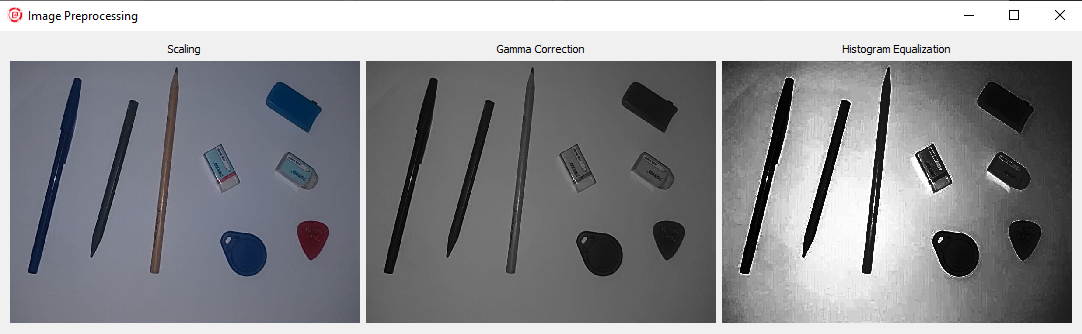

**Menampilkan Hasil Processing**

In [ ]:
class MorphologyPreview(QWidget):
    def __init__(self, threshold_img, morphology_img, labeling_img):
        super().__init__()
        self.setWindowTitle("Image Processing")
        self.setGeometry(200, 200, 1100, 250)
        self.setWindowIcon(QIcon('logo_to.ico'))
        main_layout = QHBoxLayout()

        vbox_thresh = QVBoxLayout()
        lbl_thresh_cap = QLabel("Adaptive Threshold")
        lbl_thresh_cap.setAlignment(Qt.AlignCenter)
        lbl_thresh = QLabel()
        pixmap_thresh = self.cv2qt(threshold_img, is_gray=True)
        lbl_thresh.setPixmap(pixmap_thresh.scaled(350, 350, Qt.KeepAspectRatio))
        lbl_thresh.setAlignment(Qt.AlignCenter)
        vbox_thresh.addWidget(lbl_thresh_cap)
        vbox_thresh.addWidget(lbl_thresh)

        vbox_morph = QVBoxLayout()
        lbl_morph_cap = QLabel("Dilation + Erosion + Closing")
        lbl_morph_cap.setAlignment(Qt.AlignCenter)
        lbl_morph = QLabel()
        pixmap_morph = self.cv2qt(morphology_img, is_gray=True)
        lbl_morph.setPixmap(pixmap_morph.scaled(350, 350, Qt.KeepAspectRatio))
        lbl_morph.setAlignment(Qt.AlignCenter)
        vbox_morph.addWidget(lbl_morph_cap)
        vbox_morph.addWidget(lbl_morph)

        vbox_label = QVBoxLayout()
        lbl_label_cap = QLabel("Labeling Object")
        lbl_label_cap.setAlignment(Qt.AlignCenter)
        lbl_label = QLabel()
        pixmap_label = self.cv2qt(labeling_img, is_gray=False)
        lbl_label.setPixmap(pixmap_label.scaled(350, 350, Qt.KeepAspectRatio))
        lbl_label.setAlignment(Qt.AlignCenter)
        vbox_label.addWidget(lbl_label_cap)
        vbox_label.addWidget(lbl_label)

        main_layout.addLayout(vbox_thresh)
        main_layout.addLayout(vbox_morph)
        main_layout.addLayout(vbox_label)
        self.setLayout(main_layout)

    def cv2qt(self, img, is_gray=False):
        if is_gray:
            h, w = img.shape
            return QPixmap.fromImage(QImage(img.data, w, h, w, QImage.Format_Grayscale8))
        else:
            rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            h, w, ch = rgb.shape
            return QPixmap.fromImage(QImage(rgb.data, w, h, ch * w, QImage.Format_RGB888))

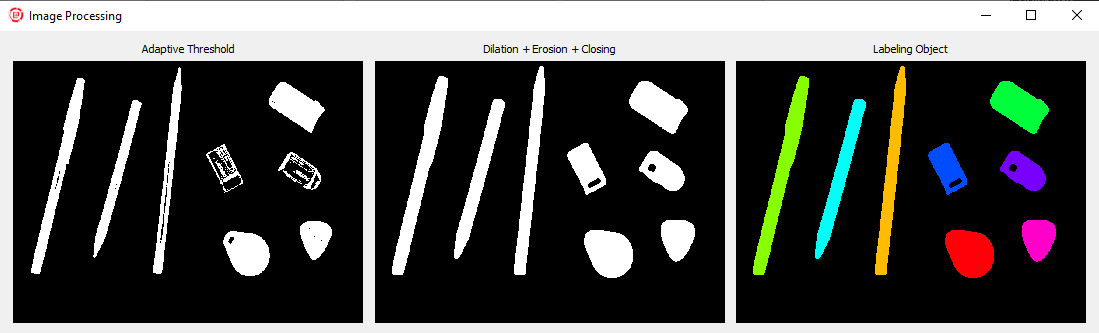

**GUI Utama Deteksi Objek**

In [ ]:
class ObjectCounterApp(QWidget):
    def __init__(self):
        super().__init__()
        self.setWindowTitle("UTS Machine Vision - TO6C")
        self.setGeometry(100, 100, 1000, 350)
        self.setWindowIcon(QIcon('logo_to.ico'))

        self.image_path = None
        self.gray_correct = None
        self.gray_equ = None
        self.thresh = None
        self.img_closed = None
        self.labeling_img = None
        self.current_post_img = None

        # Setup tombol dan label UI
        self.btn_browse = QPushButton("Pilih Gambar")
        self.btn_process = QPushButton("Mulai Deteksi")
        self.btn_process.setEnabled(False)
        self.btn_credit = QPushButton("Informasi")
        self.btn_adjustments = QPushButton("Hasil Preprocessing")
        self.btn_adjustments.setEnabled(False)
        self.btn_morph = QPushButton("Hasil Processing")
        self.btn_morph.setEnabled(False)
        self.btn_save = QPushButton("Simpan Hasil")
        self.btn_save.setEnabled(False)

        self.btn_browse.setFixedHeight(40)
        self.btn_process.setFixedHeight(40)
        self.btn_credit.setFixedHeight(40)
        self.btn_adjustments.setFixedHeight(25)
        self.btn_morph.setFixedHeight(25)
        self.btn_save.setFixedHeight(25)

        self.btn_browse.setFixedWidth(200)
        self.btn_process.setFixedWidth(200)
        self.btn_credit.setFixedWidth(200)
        self.btn_adjustments.setFixedWidth(350)
        self.btn_morph.setFixedWidth(350)
        self.btn_save.setFixedWidth(350)

        self.title_main = QLabel("OBJECT COUNTER & SEGMENTATION")
        self.title_main.setAlignment(Qt.AlignCenter)
        self.title_main.setStyleSheet("font-weight: bold; font-size: 16px; margin-bottom: 10px; margin-top: 10px;")

        self.title_preproc = QLabel("Preprocessing")
        self.title_proc = QLabel("Processing")
        self.title_post = QLabel("Post Segmentation")

        for lbl in [self.title_preproc, self.title_proc, self.title_post]:
            lbl.setAlignment(Qt.AlignCenter)
            lbl.setStyleSheet("font-size: 10pt; font-weight: bold; margin-bottom: 0px; margin-top: 20px; padding: 0px;")

        self.lbl_preprocess = QLabel()
        self.lbl_processing = QLabel()
        self.lbl_post = QLabel()

        for lbl in [self.lbl_preprocess, self.lbl_processing, self.lbl_post]:
            lbl.setFixedSize(350, 260)
            lbl.setAlignment(Qt.AlignCenter)
            lbl.setStyleSheet("border: 1px solid gray; padding: 0px; margin: 0px;")

        btn_layout = QHBoxLayout()
        btn_layout.setSpacing(10)
        btn_layout.setContentsMargins(0, 0, 0, 0)
        btn_layout.addStretch(1)
        btn_layout.addWidget(self.btn_browse)
        btn_layout.addWidget(self.btn_process)
        btn_layout.addWidget(self.btn_credit)
        btn_layout.addStretch(1)

        grid = QGridLayout()
        grid.setHorizontalSpacing(10)
        grid.setVerticalSpacing(5)
        grid.setContentsMargins(10, 5, 10, 5)
        grid.setColumnStretch(0, 1)
        grid.setColumnStretch(1, 1)
        grid.setColumnStretch(2, 1)
        grid.addWidget(self.title_preproc, 0, 0, alignment=Qt.AlignCenter)
        grid.addWidget(self.title_proc, 0, 1, alignment=Qt.AlignCenter)
        grid.addWidget(self.title_post, 0, 2, alignment=Qt.AlignCenter)
        grid.addWidget(self.lbl_preprocess, 1, 0, alignment=Qt.AlignCenter)
        grid.addWidget(self.lbl_processing, 1, 1, alignment=Qt.AlignCenter)
        grid.addWidget(self.lbl_post, 1, 2, alignment=Qt.AlignCenter)
        grid.addWidget(self.btn_adjustments, 2, 0, alignment=Qt.AlignTop)
        grid.addWidget(self.btn_morph, 2, 1, alignment=Qt.AlignTop)
        grid.addWidget(self.btn_save, 2, 2, alignment=Qt.AlignTop | Qt.AlignHCenter)

        main_layout = QVBoxLayout()
        main_layout.setSpacing(5)
        main_layout.setContentsMargins(10, 10, 10, 10)
        main_layout.addWidget(self.title_main)
        main_layout.addLayout(btn_layout)
        main_layout.addLayout(grid)
        self.setLayout(main_layout)

        self.btn_browse.clicked.connect(self.load_image)
        self.btn_process.clicked.connect(self.process_image)
        self.btn_adjustments.clicked.connect(self.show_adjustments)
        self.btn_morph.clicked.connect(self.show_morphology)
        self.btn_credit.clicked.connect(self.show_credit)
        self.btn_save.clicked.connect(self.save_post_image)

    def show_credit(self):
        QMessageBox.information(self, "Credit", "Luigi Ifan Dwiutomo (0922040056)\nMoch. Baharudin Yusuf Habibie (0922040058)")

    def load_image(self):
        fname, _ = QFileDialog.getOpenFileName(self, "Open Image", "", "Image files (*.jpg *.png *.bmp)")
        if fname:
            self.image_path = fname
            self.btn_process.setEnabled(True)
            pixmap = QPixmap(fname)
            self.lbl_preprocess.setPixmap(pixmap.scaled(350, 250, Qt.KeepAspectRatio))
            self.lbl_processing.clear()
            self.lbl_post.clear()
            self.btn_adjustments.setEnabled(False)
            self.btn_morph.setEnabled(False)
            self.btn_save.setEnabled(False)
            self.current_post_img = None

    def process_image(self):
        if not self.image_path:
            return
        original = cv.imread(self.image_path)
        original_resized = scaling(original, 800, 600)

        self.gray_correct, self.gray_equ, _ = preprocess(original_resized)
        self.thresh = threshold(self.gray_correct)
        self.img_closed, self.labeling_img = postprocess(self.thresh)
        original_disp, obj_count = draw_bounding_boxes(self.img_closed, original_resized)

        self.set_image(self.lbl_preprocess, self.gray_equ, is_gray=True)
        self.set_image(self.lbl_processing, self.labeling_img, is_gray=False)
        self.set_image(self.lbl_post, original_disp, is_gray=False)

        self.btn_adjustments.setEnabled(True)
        self.btn_morph.setEnabled(True)
        self.btn_save.setEnabled(True)
        self.current_post_img = original_disp

    def set_image(self, label, img, is_gray=False):
        if is_gray:
            if len(img.shape) == 2:
                h, w = img.shape
                qimg = QImage(img.data, w, h, w, QImage.Format_Grayscale8)
            else:
                h, w, ch = img.shape
                qimg = QImage(img.data, w, h, ch * w, QImage.Format_Grayscale8)
        else:
            img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            h, w, ch = img_rgb.shape
            qimg = QImage(img_rgb.data, w, h, ch * w, QImage.Format_RGB888)
        pixmap = QPixmap.fromImage(qimg)
        label.setPixmap(pixmap.scaled(350, 350, Qt.KeepAspectRatio, Qt.SmoothTransformation))

    def show_adjustments(self):
        if self.gray_correct is not None and self.gray_equ is not None and self.image_path is not None:
            original = cv.imread(self.image_path)
            original_resized = scaling(original, 800, 600)
            self.preview_win = AdjustmentPreview(original_resized, self.gray_correct, self.gray_equ)
            self.preview_win.show()

    def show_morphology(self):
        if self.thresh is not None and self.img_closed is not None and self.labeling_img is not None:
            self.morph_win = MorphologyPreview(self.thresh, self.img_closed, self.labeling_img)
            self.morph_win.show()

    def save_post_image(self):
        if self.current_post_img is not None:
            fname, _ = QFileDialog.getSaveFileName(
                self, "Save Result", "", "PNG Files (*.png);;All Files (*)"
            )
            if fname:
                if not fname.lower().endswith('.png'):
                    fname += '.png'
                cv.imwrite(fname, self.current_post_img)
                QMessageBox.information(self, "Saved", "Gambar berhasil disimpan!")
        else:
            QMessageBox.warning(self, "Warning", "Tidak ada gambar untuk disimpan.")

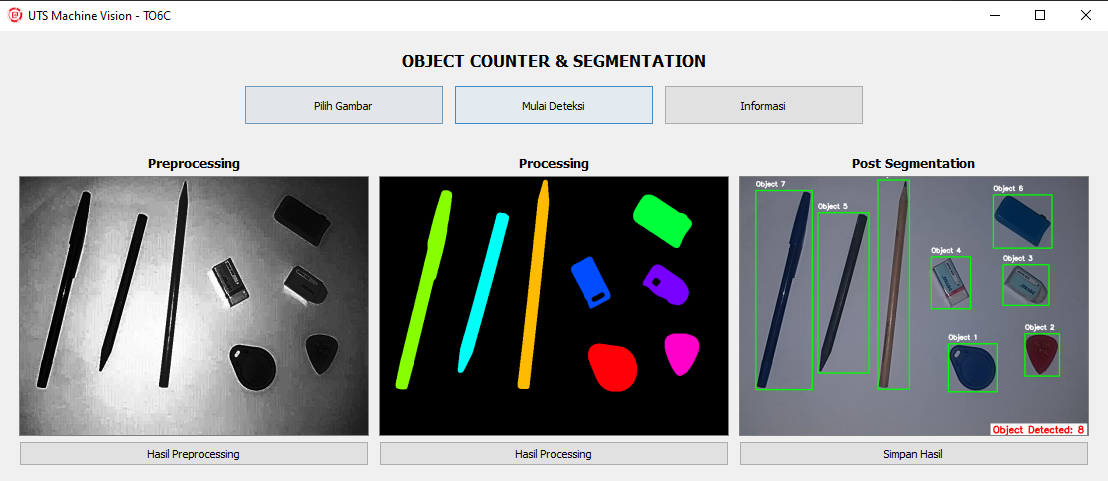

**Menjalankan Aplikasi**

In [ ]:
if __name__ == "__main__":
    app = QApplication(sys.argv) # PyQt5 application
    win = ObjectCounterApp() # Create main window
    win.show() # Show main window
    sys.exit(app.exec_()) # Exit application